In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, log_loss
import optuna
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import joblib

In [2]:
df = pd.read_excel("np_dataset.xlsx")

In [3]:
df2 = df.copy()

In [4]:
X = df2.drop('f(vij)obs', axis=1)
y = df2['f(vij)obs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

# Training and evaluation of the models

## Selected models to train

In [5]:
models = {
    "RF": RandomForestClassifier(random_state=9, criterion='gini'),
    "XGBoost": XGBClassifier(objective='binary:logistic', random_state=9, criterion='gini'),
    "DT": DecisionTreeClassifier(random_state=9, criterion='gini')
}

## Hyperparameter optimization

In [6]:
selected_features_dict = {}

# Function to select important features based on a fixed threshold
def select_important_features(model, X, y, threshold=0.05, additional_feature=None):
    model.fit(X, y)
    importances = model.feature_importances_
    print(f"Importances: {importances}")
    important_features = list(X.columns[importances > threshold])
    print(f"Features above threshold {threshold}: {important_features}")
    if additional_feature and additional_feature not in important_features:
        important_features.append(additional_feature)
        
    return important_features

In [7]:
# Optuna objective functions for each model

def rf_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 150)
    max_depth = trial.suggest_int("max_depth", 1, 10)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    model = RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, random_state=9)

    selected_features = select_important_features(model, X_train, y_train,additional_feature='Dtime(h)(cn02-cn07)')
    selected_features_dict["RF"] = selected_features
    X_train_selected = X_train[selected_features]
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=9)
    mcc_scores = []

    for train_idx, valid_idx in skf.split(X_train_selected, y_train):
        X_train_fold, X_valid_fold = X_train_selected.iloc[train_idx], X_train_selected.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        model.fit(X_train_fold, y_train_fold)
        y_valid_pred = model.predict(X_valid_fold)
        mcc = matthews_corrcoef(y_valid_fold, y_valid_pred)
        mcc_scores.append(mcc)

    return np.mean(mcc_scores)

def xgb_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 150)
    max_depth = trial.suggest_int("max_depth", 1, 10)
    learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)

    model = XGBClassifier(
        n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, 
        subsample=subsample, objective='binary:logistic', random_state=9)

    selected_features = select_important_features(model, X_train, y_train, additional_feature='Dtime(h)(cn02-cn07)')
    selected_features_dict["XGBoost"] = selected_features
    X_train_selected = X_train[selected_features]

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=9)
    mcc_scores = []

    for train_idx, valid_idx in skf.split(X_train_selected, y_train):
        X_train_fold, X_valid_fold = X_train_selected.iloc[train_idx], X_train_selected.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        model.fit(X_train_fold, y_train_fold)
        y_valid_pred = model.predict(X_valid_fold)
        mcc = matthews_corrcoef(y_valid_fold, y_valid_pred)
        mcc_scores.append(mcc)

    return np.mean(mcc_scores)

def dt_objective(trial):
    max_depth = trial.suggest_int("max_depth", 1, 10)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    model = DecisionTreeClassifier(
        max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=9, criterion='gini')

    selected_features = select_important_features(model, X_train, y_train,additional_feature='Dtime(h)(cn02-cn07)')
    selected_features_dict["DT"] = selected_features
    X_train_selected = X_train[selected_features]

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=9)
    mcc_scores = []

    for train_idx, valid_idx in skf.split(X_train_selected, y_train):
        X_train_fold, X_valid_fold = X_train_selected.iloc[train_idx], X_train_selected.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx] 
        model.fit(X_train_fold, y_train_fold)
        y_valid_pred = model.predict(X_valid_fold)
        mcc = matthews_corrcoef(y_valid_fold, y_valid_pred)
        mcc_scores.append(mcc)

    return np.mean(mcc_scores)

In [8]:
# Run Optuna optimizations
studies = {
    "RF": optuna.create_study(direction='maximize'),
    "XGBoost": optuna.create_study(direction='maximize'),
    "DT": optuna.create_study(direction='maximize')
}

studies["RF"].optimize(rf_objective, n_trials=50)
studies["XGBoost"].optimize(xgb_objective, n_trials=50)
studies["DT"].optimize(dt_objective, n_trials=50)

[I 2024-09-26 15:16:47,886] A new study created in memory with name: no-name-2121052d-28b1-447b-9f09-093fa9c4c23b
[I 2024-09-26 15:16:47,887] A new study created in memory with name: no-name-47a30cae-58a2-4792-951f-415ed9080794
[I 2024-09-26 15:16:47,888] A new study created in memory with name: no-name-a466124e-9631-49c7-8d9a-38e832e9d1cd
[I 2024-09-26 15:16:47,986] Trial 0 finished with value: 0.6897886730523353 and parameters: {'n_estimators': 17, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 0 with value: 0.6897886730523353.


Importances: [0.27175248 0.01311533 0.07512773 0.1587806  0.0590055  0.03505841
 0.03242905 0.14126143 0.02789393 0.02415582 0.05392161 0.01816189
 0.05570868 0.03157029 0.00205725]
Features above threshold 0.05: ['f(vij)npref', 'DNMUnp(cn02-cn07)', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)', 'DEnpu(cn08-cn10)']
Importances: [0.31737194 0.01726902 0.05530496 0.13474696 0.04714988 0.05132179
 0.03040438 0.13423274 0.04954332 0.02465939 0.04701157 0.01623672
 0.04069451 0.02346438 0.01058844]
Features above threshold 0.05: ['f(vij)npref', 'DNMUnp(cn02-cn07)', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)']


[I 2024-09-26 15:16:48,598] Trial 1 finished with value: 0.7300475898239548 and parameters: {'n_estimators': 149, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 1 with value: 0.7300475898239548.
[I 2024-09-26 15:16:48,814] Trial 2 finished with value: 0.6457382217485222 and parameters: {'n_estimators': 57, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 1 with value: 0.7300475898239548.


Importances: [0.36290289 0.01710048 0.05764959 0.13682603 0.06195237 0.03243285
 0.03287707 0.1297965  0.03055316 0.02270779 0.03436368 0.01506964
 0.04587532 0.01661626 0.00327639]
Features above threshold 0.05: ['f(vij)npref', 'DNMUnp(cn02-cn07)', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)']
Importances: [0.26981691 0.01802263 0.06816656 0.13536411 0.06062936 0.01918149
 0.03987476 0.13426992 0.03820543 0.03069868 0.06685838 0.01956451
 0.06787721 0.02855696 0.00291308]
Features above threshold 0.05: ['f(vij)npref', 'DNMUnp(cn02-cn07)', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)', 'DEnpu(cn08-cn10)']


[I 2024-09-26 15:16:48,880] Trial 3 finished with value: 0.6835321186574715 and parameters: {'n_estimators': 16, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 1 with value: 0.7300475898239548.
[I 2024-09-26 15:16:49,117] Trial 4 finished with value: 0.5948811657312646 and parameters: {'n_estimators': 62, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 1 with value: 0.7300475898239548.


Importances: [0.30829819 0.00054418 0.11126268 0.12583426 0.08217215 0.03848987
 0.03216405 0.14435579 0.03179383 0.00459157 0.02934938 0.00748691
 0.04711569 0.02924322 0.00729824]
Features above threshold 0.05: ['f(vij)npref', 'DNMUnp(cn02-cn07)', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)']
Importances: [0.30503775 0.02069377 0.04774012 0.12287912 0.05596162 0.03989994
 0.04047212 0.11931094 0.04141288 0.02917289 0.07210992 0.01987221
 0.04878291 0.02702345 0.00963037]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)']


[I 2024-09-26 15:16:49,533] Trial 5 finished with value: 0.6845962804300761 and parameters: {'n_estimators': 109, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 1 with value: 0.7300475898239548.


Importances: [0.33925536 0.00847602 0.05975618 0.13713641 0.05169539 0.03688649
 0.02964429 0.16421517 0.03291527 0.01959776 0.05229602 0.01374497
 0.03317782 0.01825453 0.00294832]
Features above threshold 0.05: ['f(vij)npref', 'DNMUnp(cn02-cn07)', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)']


[I 2024-09-26 15:16:49,906] Trial 6 finished with value: 0.6886994067163741 and parameters: {'n_estimators': 131, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 1 with value: 0.7300475898239548.


Importances: [0.36452286 0.01403243 0.05779591 0.14739041 0.04974176 0.03870066
 0.02718604 0.1425986  0.03605692 0.01843201 0.04159437 0.01006989
 0.02990779 0.01837508 0.00359526]
Features above threshold 0.05: ['f(vij)npref', 'DNMUnp(cn02-cn07)', 'DLnp(cn02-cn07)', 'DLASAcoat(cn02-cn07)']


[I 2024-09-26 15:16:50,391] Trial 7 finished with value: 0.6411361255980287 and parameters: {'n_estimators': 137, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 1 with value: 0.7300475898239548.
[I 2024-09-26 15:16:50,561] Trial 8 finished with value: 0.662717422677753 and parameters: {'n_estimators': 57, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 1 with value: 0.7300475898239548.


Importances: [0.35482605 0.00925301 0.06679412 0.12668184 0.06443537 0.03950558
 0.02564539 0.15217237 0.03055285 0.01837996 0.04165405 0.01786201
 0.03500292 0.01546768 0.0017668 ]
Features above threshold 0.05: ['f(vij)npref', 'DNMUnp(cn02-cn07)', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)']
Importances: [0.33320848 0.00855758 0.06030629 0.11180645 0.04418428 0.05907028
 0.02792446 0.13000017 0.03880135 0.03394401 0.05606848 0.02054993
 0.04976125 0.02332828 0.00248871]
Features above threshold 0.05: ['f(vij)npref', 'DNMUnp(cn02-cn07)', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)']


[I 2024-09-26 15:16:50,688] Trial 9 finished with value: 0.7060947876995431 and parameters: {'n_estimators': 39, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 8, 'bootstrap': False}. Best is trial 1 with value: 0.7300475898239548.


Importances: [0.19417476 0.00970874 0.12621359 0.12621359 0.11650485 0.01941748
 0.05825243 0.16504854 0.04854369 0.00970874 0.05825243 0.01941748
 0.01941748 0.01941748 0.00970874]
Features above threshold 0.05: ['f(vij)npref', 'DNMUnp(cn02-cn07)', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DPnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)']


[I 2024-09-26 15:16:51,048] Trial 10 finished with value: 0.5122864679703768 and parameters: {'n_estimators': 103, 'max_depth': 1, 'min_samples_split': 2, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 1 with value: 0.7300475898239548.
[I 2024-09-26 15:16:51,321] Trial 11 finished with value: 0.7405285976134675 and parameters: {'n_estimators': 85, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 11 with value: 0.7405285976134675.


Importances: [0.31213825 0.00991477 0.04960074 0.1189532  0.05074981 0.05949922
 0.02855085 0.12537084 0.04053972 0.03340657 0.07118215 0.02191536
 0.04868659 0.02463464 0.00485729]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)']
Importances: [0.31938326 0.01906523 0.0416243  0.13420903 0.05079502 0.05028929
 0.03143555 0.12531162 0.04518921 0.02973612 0.0585209  0.01859893
 0.04256789 0.02342103 0.00985261]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)']


[I 2024-09-26 15:16:51,886] Trial 12 finished with value: 0.729872568863117 and parameters: {'n_estimators': 149, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 11 with value: 0.7405285976134675.


Importances: [0.31535881 0.01546464 0.04763382 0.11750261 0.04938842 0.05338567
 0.03348221 0.12237877 0.03995832 0.02894557 0.07739813 0.02246429
 0.04654029 0.0230041  0.00709436]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)']


[I 2024-09-26 15:16:52,188] Trial 13 finished with value: 0.7174885540498535 and parameters: {'n_estimators': 92, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 11 with value: 0.7405285976134675.


Importances: [0.36612692 0.01904292 0.05617434 0.13851211 0.05462615 0.04510848
 0.02458378 0.12238908 0.03902818 0.02375086 0.04509894 0.01539117
 0.0298451  0.0165263  0.00379568]
Features above threshold 0.05: ['f(vij)npref', 'DNMUnp(cn02-cn07)', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)']


[I 2024-09-26 15:16:52,631] Trial 14 finished with value: 0.6649316062794658 and parameters: {'n_estimators': 115, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 11 with value: 0.7405285976134675.
[I 2024-09-26 15:16:52,888] Trial 15 finished with value: 0.7067310957893036 and parameters: {'n_estimators': 78, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 11 with value: 0.7405285976134675.


Importances: [0.31775863 0.01503547 0.04054456 0.11148189 0.04974874 0.04962911
 0.03945441 0.12665784 0.03270333 0.03336612 0.06665624 0.02768466
 0.05069782 0.02999855 0.00858263]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)', 'DEnpu(cn08-cn10)']
Importances: [0.31496978 0.01616933 0.04732643 0.11221014 0.05122268 0.05744428
 0.03373762 0.12150664 0.03622702 0.03429167 0.07349135 0.02411165
 0.04772528 0.02338489 0.00618124]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)']


[I 2024-09-26 15:16:53,178] Trial 16 finished with value: 0.7299003127223475 and parameters: {'n_estimators': 80, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 11 with value: 0.7405285976134675.


Importances: [0.36112439 0.01832896 0.04972493 0.14263883 0.04994605 0.04449142
 0.02639058 0.13503787 0.03346713 0.01967203 0.04666211 0.01398541
 0.03796916 0.01554926 0.00501185]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DLASAcoat(cn02-cn07)']


[I 2024-09-26 15:16:53,652] Trial 17 finished with value: 0.6775069102016208 and parameters: {'n_estimators': 124, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 11 with value: 0.7405285976134675.


Importances: [0.358838   0.01737795 0.04510886 0.13611776 0.04762608 0.05340963
 0.02941469 0.12080941 0.03713885 0.02897262 0.05242236 0.01597765
 0.03252041 0.01911602 0.00514972]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)']


[I 2024-09-26 15:16:54,216] Trial 18 finished with value: 0.6742562062522012 and parameters: {'n_estimators': 149, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 11 with value: 0.7405285976134675.
[I 2024-09-26 15:16:54,334] Trial 19 finished with value: 0.6545825850660129 and parameters: {'n_estimators': 35, 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 11 with value: 0.7405285976134675.


Importances: [0.28156375 0.         0.0999227  0.10538013 0.09249079 0.04867634
 0.05418541 0.20628231 0.01744433 0.00036253 0.03120397 0.00172177
 0.04180984 0.01467063 0.00428551]
Features above threshold 0.05: ['f(vij)npref', 'DNMUnp(cn02-cn07)', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DPnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)']
Importances: [0.31357256 0.01659187 0.05359534 0.15128689 0.05787122 0.04825572
 0.02789745 0.13147274 0.03801865 0.02207687 0.0538577  0.01661479
 0.03893254 0.01949195 0.01046371]
Features above threshold 0.05: ['f(vij)npref', 'DNMUnp(cn02-cn07)', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)']


[I 2024-09-26 15:16:54,717] Trial 20 finished with value: 0.6889078639796707 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 11 with value: 0.7405285976134675.


Importances: [0.31658621 0.01596971 0.04674215 0.11153399 0.05118065 0.0567351
 0.03332111 0.12119222 0.03612743 0.03386831 0.07352193 0.02407335
 0.04876225 0.02361134 0.00677424]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)']


[I 2024-09-26 15:16:55,030] Trial 21 finished with value: 0.7299003127223475 and parameters: {'n_estimators': 81, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 11 with value: 0.7405285976134675.
[I 2024-09-26 15:16:55,324] Trial 22 finished with value: 0.7420439512086964 and parameters: {'n_estimators': 73, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 22 with value: 0.7420439512086964.


Importances: [0.31446378 0.01494522 0.04773343 0.11341923 0.05210583 0.05149815
 0.03467541 0.12184974 0.0381877  0.03476331 0.07245581 0.02240363
 0.04927474 0.02504703 0.00717698]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)']


[I 2024-09-26 15:16:55,597] Trial 23 finished with value: 0.7206653613762581 and parameters: {'n_estimators': 69, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 22 with value: 0.7420439512086964.


Importances: [0.31197004 0.01921541 0.04326483 0.1214738  0.05325809 0.04255953
 0.03243447 0.13290756 0.03208006 0.0331959  0.06868159 0.02381068
 0.05047066 0.02705651 0.00762086]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)', 'DEnpu(cn08-cn10)']


[I 2024-09-26 15:16:55,742] Trial 24 finished with value: 0.7371657474181172 and parameters: {'n_estimators': 34, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 22 with value: 0.7420439512086964.


Importances: [0.3210264  0.01590869 0.04917448 0.10207774 0.04662987 0.04674368
 0.0334991  0.14027693 0.03156833 0.03381923 0.05277984 0.02816974
 0.06197264 0.03007963 0.0062737 ]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)', 'DEnpu(cn08-cn10)']
Importances: [0.3082494  0.01507611 0.04652308 0.10766271 0.04593425 0.04888372
 0.0333283  0.15343036 0.0319495  0.03329537 0.05518095 0.03050024
 0.05580609 0.0269261  0.0072538 ]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)', 'DEnpu(cn08-cn10)']


[I 2024-09-26 15:16:55,904] Trial 25 finished with value: 0.7438133038307436 and parameters: {'n_estimators': 44, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 25 with value: 0.7438133038307436.
[I 2024-09-26 15:16:56,074] Trial 26 finished with value: 0.7303279539244364 and parameters: {'n_estimators': 45, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 25 with value: 0.7438133038307436.


Importances: [0.28944295 0.01945141 0.04032979 0.08668879 0.04787642 0.04589195
 0.037324   0.15001691 0.04252158 0.04329489 0.0657919  0.03678427
 0.05476494 0.03223712 0.00758308]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)', 'DEnpu(cn08-cn10)']
Importances: [0.29827781 0.01867527 0.03993401 0.10363578 0.05295207 0.05799128
 0.03953521 0.1197262  0.04107924 0.03301017 0.06668459 0.03283487
 0.0552173  0.0303308  0.0101154 ]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)', 'DEnpu(cn08-cn10)']


[I 2024-09-26 15:16:56,421] Trial 27 finished with value: 0.7653777547445592 and parameters: {'n_estimators': 92, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 27 with value: 0.7653777547445592.
[I 2024-09-26 15:16:56,640] Trial 28 finished with value: 0.7720705685757806 and parameters: {'n_estimators': 47, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 28 with value: 0.7720705685757806.


Importances: [0.29303961 0.02224697 0.03803504 0.09669901 0.04834186 0.06006651
 0.03569263 0.12934045 0.04312254 0.03545037 0.05834028 0.03922757
 0.05344877 0.03421776 0.01273063]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)', 'DEnpu(cn08-cn10)']
Importances: [0.28930703 0.02247474 0.04023274 0.12314421 0.05447196 0.05360816
 0.02897756 0.12966441 0.03253849 0.02714873 0.05040219 0.04010917
 0.06249115 0.03822063 0.00720882]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)', 'DEnpu(cn08-cn10)']


[I 2024-09-26 15:16:56,764] Trial 29 finished with value: 0.7438508916677592 and parameters: {'n_estimators': 25, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 28 with value: 0.7720705685757806.
[I 2024-09-26 15:16:56,871] Trial 30 finished with value: 0.764741449893731 and parameters: {'n_estimators': 25, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 28 with value: 0.7720705685757806.
[I 2024-09-26 15:16:56,985] Trial 31 finished with value: 0.7583486343175255 and parameters: {'n_estimators': 26, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 28 with value: 0.7720705685757806.


Importances: [0.31981123 0.01696519 0.04232378 0.13479796 0.05617162 0.05393763
 0.03137064 0.12526349 0.02159969 0.02404674 0.04709306 0.02606176
 0.05288368 0.04373647 0.00393705]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DEnpu(cn08-cn10)']
Importances: [0.3187023  0.01702314 0.04069594 0.13227444 0.05488518 0.05233674
 0.0311666  0.13203653 0.02078601 0.02312187 0.04528179 0.02710877
 0.05670393 0.0420543  0.00582246]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DEnpu(cn08-cn10)']


[I 2024-09-26 15:16:57,051] Trial 32 finished with value: 0.6777172834819574 and parameters: {'n_estimators': 11, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 28 with value: 0.7720705685757806.
[I 2024-09-26 15:16:57,175] Trial 33 finished with value: 0.7044158338724563 and parameters: {'n_estimators': 25, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 28 with value: 0.7720705685757806.


Importances: [0.30106851 0.02014158 0.05398587 0.10529272 0.07311018 0.03773891
 0.04090745 0.13109944 0.01324892 0.02189658 0.06560734 0.03404863
 0.06303484 0.03537299 0.00344604]
Features above threshold 0.05: ['f(vij)npref', 'DNMUnp(cn02-cn07)', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)', 'DEnpu(cn08-cn10)']
Importances: [0.32157659 0.01523255 0.05642042 0.11198581 0.05358838 0.04605407
 0.03015095 0.14238934 0.02487081 0.02423342 0.05739929 0.02860066
 0.04573884 0.04031098 0.0014479 ]
Features above threshold 0.05: ['f(vij)npref', 'DNMUnp(cn02-cn07)', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)']
Importances: [0.30270553 0.00941001 0.05016098 0.1646382  0.05855737 0.04441736
 0.03287684 0.15187547 0.02530152 0.01365562 0.04981568 0.02280817
 0.04289932 0.02683184 0.00404607]
Features above threshold 0.05: ['f(vij)npref', 'DNMUnp(cn02-cn07)', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)']


[I 2024-09-26 15:16:57,273] Trial 34 finished with value: 0.7441202427546374 and parameters: {'n_estimators': 22, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 28 with value: 0.7720705685757806.
[I 2024-09-26 15:16:57,458] Trial 35 finished with value: 0.7482448914964225 and parameters: {'n_estimators': 52, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 28 with value: 0.7720705685757806.


Importances: [0.33895617 0.01307058 0.053295   0.101081   0.05284314 0.05403769
 0.03050045 0.13511744 0.02918765 0.02666285 0.05719806 0.03365268
 0.03930507 0.03226465 0.00282758]
Features above threshold 0.05: ['f(vij)npref', 'DNMUnp(cn02-cn07)', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)']
Importances: [0.35564546 0.00231026 0.06753078 0.11185304 0.05290089 0.03784666
 0.03736607 0.17642968 0.04728084 0.0077227  0.03669151 0.00330635
 0.04004095 0.01970797 0.00336684]
Features above threshold 0.05: ['f(vij)npref', 'DNMUnp(cn02-cn07)', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)']


[I 2024-09-26 15:16:57,601] Trial 36 finished with value: 0.6349033472578922 and parameters: {'n_estimators': 29, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 28 with value: 0.7720705685757806.
[I 2024-09-26 15:16:57,715] Trial 37 finished with value: 0.7418799109588728 and parameters: {'n_estimators': 15, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 28 with value: 0.7720705685757806.


Importances: [0.25537487 0.02488916 0.0686557  0.12423744 0.0620743  0.05309512
 0.03022209 0.14383094 0.03400967 0.02398434 0.06197122 0.03363229
 0.04754549 0.02541476 0.0110626 ]
Features above threshold 0.05: ['f(vij)npref', 'DNMUnp(cn02-cn07)', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)']
Importances: [0.31884638 0.01781778 0.04148676 0.11213724 0.05079395 0.05148236
 0.04022928 0.12637282 0.03231895 0.03386187 0.05969178 0.02689056
 0.044592   0.03280009 0.01067817]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)']


[I 2024-09-26 15:16:58,074] Trial 38 finished with value: 0.726529278255723 and parameters: {'n_estimators': 65, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 28 with value: 0.7720705685757806.
[I 2024-09-26 15:16:58,293] Trial 39 finished with value: 0.7380494478427412 and parameters: {'n_estimators': 51, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 28 with value: 0.7720705685757806.


Importances: [0.31059235 0.0129002  0.05766769 0.13002626 0.05189351 0.04663878
 0.03347638 0.14258511 0.03494456 0.02189327 0.06078214 0.02441408
 0.0370679  0.02866774 0.00645001]
Features above threshold 0.05: ['f(vij)npref', 'DNMUnp(cn02-cn07)', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)']
Importances: [0.26629882 0.01606624 0.06392473 0.13892898 0.06159248 0.03881437
 0.027447   0.14032741 0.0378895  0.02930319 0.04875253 0.02540711
 0.0565143  0.04380554 0.0049278 ]
Features above threshold 0.05: ['f(vij)npref', 'DNMUnp(cn02-cn07)', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DEnpu(cn08-cn10)']


[I 2024-09-26 15:16:58,394] Trial 40 finished with value: 0.7563205251895474 and parameters: {'n_estimators': 19, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 28 with value: 0.7720705685757806.
[I 2024-09-26 15:16:58,494] Trial 41 finished with value: 0.750795907303353 and parameters: {'n_estimators': 20, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 28 with value: 0.7720705685757806.
[I 2024-09-26 15:16:58,562] Trial 42 finished with value: 0.7346703079016116 and parameters: {'n_estimators': 11, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 28 with value: 0.7720705685757806.


Importances: [0.2779332  0.01563526 0.06108795 0.13843578 0.05851285 0.03794245
 0.02607465 0.14023518 0.03845321 0.02949416 0.04676844 0.02555638
 0.05757381 0.04161526 0.00468141]
Features above threshold 0.05: ['f(vij)npref', 'DNMUnp(cn02-cn07)', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DEnpu(cn08-cn10)']
Importances: [0.27315894 0.02460786 0.07301553 0.14160662 0.07445313 0.02869203
 0.03567024 0.12813713 0.03038058 0.0192736  0.05878654 0.02882352
 0.05546058 0.02621325 0.00172046]
Features above threshold 0.05: ['f(vij)npref', 'DNMUnp(cn02-cn07)', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)', 'DEnpu(cn08-cn10)']
Importances: [0.29871269 0.01943104 0.05050016 0.10826577 0.05161895 0.05860301
 0.02971852 0.13713167 0.02426051 0.03052769 0.06179921 0.03330838
 0.04852961 0.03574428 0.0118485 ]
Features above threshold 0.05: ['f(vij)npref', 'DNMUnp(cn02-cn07)', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASA

[I 2024-09-26 15:16:58,688] Trial 43 finished with value: 0.7298648928627097 and parameters: {'n_estimators': 31, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 28 with value: 0.7720705685757806.
[I 2024-09-26 15:16:58,845] Trial 44 finished with value: 0.7661585219028585 and parameters: {'n_estimators': 42, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 28 with value: 0.7720705685757806.


Importances: [0.28095117 0.01987433 0.04734177 0.11578561 0.04879391 0.05426546
 0.03045911 0.13563508 0.04430428 0.02780719 0.05766818 0.03869396
 0.0575982  0.03121521 0.00960655]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)', 'DEnpu(cn08-cn10)']
Importances: [0.29180766 0.02202922 0.0351482  0.09147315 0.05170734 0.05951544
 0.03407988 0.13047915 0.04755474 0.03417981 0.05839882 0.03579332
 0.05740521 0.03782355 0.01260452]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)', 'DEnpu(cn08-cn10)']


[I 2024-09-26 15:16:58,996] Trial 45 finished with value: 0.7560204389353297 and parameters: {'n_estimators': 39, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 28 with value: 0.7720705685757806.
[I 2024-09-26 15:16:59,288] Trial 46 finished with value: 0.73758939054528 and parameters: {'n_estimators': 90, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 28 with value: 0.7720705685757806.


Importances: [0.31074908 0.01356158 0.04141028 0.1070511  0.05174815 0.05425131
 0.04024217 0.13996038 0.03609095 0.03322213 0.06171786 0.02519398
 0.0493358  0.02667657 0.00878868]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)']


[I 2024-09-26 15:16:59,492] Trial 47 finished with value: 0.7497006372693803 and parameters: {'n_estimators': 58, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 28 with value: 0.7720705685757806.


Importances: [0.30619382 0.01762954 0.03778734 0.09346495 0.05317822 0.05806601
 0.0397924  0.12380542 0.04145587 0.03101726 0.0662067  0.03345184
 0.05547217 0.0307197  0.01175876]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)', 'DEnpu(cn08-cn10)']
Importances: [0.33286425 0.01295934 0.05008054 0.09492796 0.04864995 0.04662878
 0.03334623 0.14601913 0.03213004 0.03115985 0.05499492 0.03823229
 0.04432035 0.02904773 0.00463865]
Features above threshold 0.05: ['f(vij)npref', 'DNMUnp(cn02-cn07)', 'DLnp(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)']


[I 2024-09-26 15:16:59,657] Trial 48 finished with value: 0.6903570428531917 and parameters: {'n_estimators': 46, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 28 with value: 0.7720705685757806.
[I 2024-09-26 15:16:59,796] Trial 49 finished with value: 0.6999089197805323 and parameters: {'n_estimators': 38, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 28 with value: 0.7720705685757806.
C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)


Importances: [0.31462096 0.00800046 0.05397003 0.13079231 0.06419971 0.05082919
 0.03431565 0.14566889 0.03233742 0.01798223 0.05437084 0.01605948
 0.04572208 0.02553338 0.00559737]
Features above threshold 0.05: ['f(vij)npref', 'DNMUnp(cn02-cn07)', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)']


[I 2024-09-26 15:17:00,093] Trial 0 finished with value: 0.7255155628135629 and parameters: {'n_estimators': 80, 'max_depth': 8, 'learning_rate': 0.028224433717414538, 'subsample': 0.5099085738289858}. Best is trial 0 with value: 0.7255155628135629.


Importances: [0.2931524  0.04363094 0.01884707 0.05700087 0.04073398 0.07648338
 0.03499236 0.07672664 0.05848744 0.04837964 0.0385945  0.05519074
 0.06545894 0.04982845 0.04249272]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)']
Importances: [0.2593939  0.03434605 0.01644901 0.05347721 0.03270867 0.06432969
 0.03996763 0.09528024 0.06014388 0.04410631 0.0408341  0.05735847
 0.07709333 0.05673003 0.0677814 ]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)', 'DLASAcoat*Degree of polym(cn08-cn10)']


C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:00,261] Trial 1 finished with value: 0.7707994680402303 and parameters: {'n_estimators': 88, 'max_depth': 6, 'learning_rate': 0.05258562830941662, 'subsample': 0.8161592301622183}. Best is trial 1 with value: 0.7707994680402303.
C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:00,505] Trial 2 finished with value: 0.7426

Importances: [0.2947624  0.02866896 0.01030235 0.0721398  0.01843035 0.07326157
 0.05793558 0.08623756 0.05619843 0.04150062 0.03245022 0.04929138
 0.07278549 0.07502191 0.03101344]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DPnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)']


C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:00,689] Trial 3 finished with value: 0.7256372591937219 and parameters: {'n_estimators': 107, 'max_depth': 5, 'learning_rate': 0.01100203417942833, 'subsample': 0.9007548419633418}. Best is trial 1 with value: 0.7707994680402303.
C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:00,730] Trial 4 finished with value: 0.604

Importances: [0.29597887 0.02676441 0.00416542 0.07561462 0.0204635  0.07582399
 0.05696632 0.07929877 0.05617501 0.02819761 0.0352494  0.04542357
 0.07121687 0.07349108 0.05517058]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DPnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)', 'DLASAcoat*Degree of polym(cn08-cn10)']
Importances: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Features above threshold 0.05: ['f(vij)npref']
Importances: [0.3962182  0.         0.         0.10947073 0.         0.10086686
 0.         0.09828082 0.08577411 0.05575055 0.         0.07554913
 0.07808965 0.         0.        ]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'Dtime(h)(cn08-cn10)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)']


C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:00,847] Trial 5 finished with value: 0.6578155711103988 and parameters: {'n_estimators': 96, 'max_depth': 2, 'learning_rate': 0.015840061001285856, 'subsample': 0.9055511486857508}. Best is trial 1 with value: 0.7707994680402303.
C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:00,918] Trial 6 finished with value: 0.618

Importances: [0.28592327 0.         0.         0.13280706 0.077412   0.09321362
 0.         0.13601401 0.06598337 0.         0.05853818 0.
 0.08113824 0.0689702  0.        ]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DLnp(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)']
Importances: [0.26745978 0.03499115 0.02741013 0.04857562 0.02826209 0.06622022
 0.02964603 0.1256228  0.07693836 0.04083988 0.04047677 0.06650533
 0.07393558 0.07311618 0.        ]
Features above threshold 0.05: ['f(vij)npref', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)']


[I 2024-09-26 15:17:01,088] Trial 7 finished with value: 0.8069051116188941 and parameters: {'n_estimators': 132, 'max_depth': 4, 'learning_rate': 0.10824623233607099, 'subsample': 0.9866059906161169}. Best is trial 7 with value: 0.8069051116188941.
C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:01,177] Trial 8 finished with value: 0.7527341777303994 and parameters: {'n_estimators': 37, 'max_depth': 7, 'learning_rate': 0.21264036667965588, 'subsample': 0.5610404880668516}. Best is trial 7 with value: 0.8069051116188941.
C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be rem

Importances: [0.2823006  0.03015387 0.02545564 0.07214657 0.04456748 0.06420574
 0.04499934 0.10512353 0.07441287 0.03773057 0.0359816  0.0357146
 0.06184438 0.05976525 0.02559797]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)']
Importances: [0.23113124 0.04150765 0.03352857 0.0705072  0.04796688 0.07609582
 0.03625418 0.08081745 0.06574649 0.04787669 0.04684488 0.06443661
 0.06432063 0.04012142 0.05284437]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DLASAcoat*Degree of polym(cn08-cn10)']


[I 2024-09-26 15:17:01,327] Trial 9 finished with value: 0.7299325141264098 and parameters: {'n_estimators': 143, 'max_depth': 2, 'learning_rate': 0.08152405741413653, 'subsample': 0.5863273670991961}. Best is trial 7 with value: 0.8069051116188941.
C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:01,511] Trial 10 finished with value: 0.8116710531806554 and parameters: {'n_estimators': 123, 'max_depth': 4, 'learning_rate': 0.2310241659148297, 'subsample': 0.9759985239523834}. Best is trial 10 with value: 0.8116710531806554.
C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be r

Importances: [0.26630685 0.03428451 0.00772405 0.03643604 0.02695274 0.05959645
 0.03259125 0.13055374 0.0600077  0.03764379 0.03119528 0.06533631
 0.07024672 0.09162906 0.04949559]
Features above threshold 0.05: ['f(vij)npref', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)']
Importances: [0.25749287 0.03447439 0.03179102 0.03847453 0.02834692 0.04548311
 0.03186662 0.15253052 0.04751173 0.04601235 0.02949644 0.09194081
 0.07123564 0.09334303 0.        ]
Features above threshold 0.05: ['f(vij)npref', 'DLASAcoat(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)']


[I 2024-09-26 15:17:01,689] Trial 11 finished with value: 0.8272254697158953 and parameters: {'n_estimators': 121, 'max_depth': 4, 'learning_rate': 0.2872545856008539, 'subsample': 0.9735559663064822}. Best is trial 11 with value: 0.8272254697158953.
C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:01,887] Trial 12 finished with value: 0.7949741854022537 and parameters: {'n_estimators': 116, 'max_depth': 10, 'learning_rate': 0.2407710606621431, 'subsample': 0.9808495378874595}. Best is trial 11 with value: 0.8272254697158953.


Importances: [0.26274857 0.0352592  0.01323837 0.03837958 0.02008475 0.05013757
 0.03054764 0.13606286 0.05589922 0.03359962 0.03073173 0.0614025
 0.07876606 0.09818126 0.05496117]
Features above threshold 0.05: ['f(vij)npref', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)', 'DLASAcoat*Degree of polym(cn08-cn10)']
Importances: [0.24877608 0.03699851 0.053817   0.04610031 0.04561614 0.06211973
 0.02563026 0.11301874 0.06619586 0.0326679  0.03119035 0.05780353
 0.1261013  0.04423377 0.00973054]
Features above threshold 0.05: ['f(vij)npref', 'DNMUnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)']


C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:02,065] Trial 13 finished with value: 0.8007140129123506 and parameters: {'n_estimators': 122, 'max_depth': 4, 'learning_rate': 0.29133650291751956, 'subsample': 0.6960160918468192}. Best is trial 11 with value: 0.8272254697158953.
C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:02,212] Trial 14 finished with value: 0.

Importances: [0.25300106 0.02693961 0.0250554  0.05661773 0.03604579 0.06689326
 0.03542497 0.11583693 0.08397256 0.04326552 0.04461753 0.06624708
 0.06803659 0.05656823 0.02147772]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)']
Importances: [0.28085563 0.02907927 0.03353522 0.0456555  0.05088776 0.07092705
 0.03134292 0.08877509 0.06545887 0.03510062 0.03327689 0.04562197
 0.08869971 0.03420775 0.06657576]
Features above threshold 0.05: ['f(vij)npref', 'DVnpu(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DEnpu(cn08-cn10)', 'DLASAcoat*Degree of polym(cn08-cn10)']


[I 2024-09-26 15:17:02,389] Trial 15 finished with value: 0.8009400999492756 and parameters: {'n_estimators': 107, 'max_depth': 4, 'learning_rate': 0.16210883949114388, 'subsample': 0.6702523379227843}. Best is trial 11 with value: 0.8272254697158953.
C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:02,568] Trial 16 finished with value: 0.7563510105691146 and parameters: {'n_estimators': 63, 'max_depth': 8, 'learning_rate': 0.054262945052303585, 'subsample': 0.9543971634663632}. Best is trial 11 with value: 0.8272254697158953.
C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will b

Importances: [0.26726624 0.03531177 0.00883672 0.06504457 0.02466856 0.07057253
 0.0487556  0.09998935 0.05795083 0.04622958 0.04166758 0.05188556
 0.08734699 0.07141569 0.02305843]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)']
Importances: [0.2512953  0.0263762  0.01945156 0.03736919 0.03393015 0.0574042
 0.03825697 0.1133164  0.05929547 0.0391596  0.03126208 0.05492632
 0.08756893 0.0750932  0.07529446]
Features above threshold 0.05: ['f(vij)npref', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)', 'DLASAcoat*Degree of polym(cn08-cn10)']


[I 2024-09-26 15:17:02,822] Trial 17 finished with value: 0.8179002408068176 and parameters: {'n_estimators': 149, 'max_depth': 5, 'learning_rate': 0.16587702359334636, 'subsample': 0.8595749046752578}. Best is trial 11 with value: 0.8272254697158953.
C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:03,078] Trial 18 finished with value: 0.8007140129123506 and parameters: {'n_estimators': 149, 'max_depth': 5, 'learning_rate': 0.08038815817134555, 'subsample': 0.8641069942690432}. Best is trial 11 with value: 0.8272254697158953.


Importances: [0.25431818 0.03250147 0.02666094 0.04222927 0.03259658 0.06932416
 0.03776336 0.10023531 0.07626007 0.04001084 0.03403845 0.05818448
 0.06657334 0.05608721 0.07321634]
Features above threshold 0.05: ['f(vij)npref', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)', 'DLASAcoat*Degree of polym(cn08-cn10)']


C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:03,319] Trial 19 finished with value: 0.7883849218682832 and parameters: {'n_estimators': 131, 'max_depth': 7, 'learning_rate': 0.1480965073826738, 'subsample': 0.7729013114716309}. Best is trial 11 with value: 0.8272254697158953.


Importances: [0.27524844 0.02776163 0.03586984 0.04180376 0.0393821  0.06449202
 0.03780456 0.1094997  0.07237804 0.04381102 0.03058972 0.04644789
 0.08555144 0.05178736 0.03757245]
Features above threshold 0.05: ['f(vij)npref', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)']


C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:03,546] Trial 20 finished with value: 0.7951679552434326 and parameters: {'n_estimators': 103, 'max_depth': 10, 'learning_rate': 0.08317277375574345, 'subsample': 0.8718731015882236}. Best is trial 11 with value: 0.8272254697158953.


Importances: [0.24716492 0.03196157 0.02146431 0.04644197 0.03433268 0.06754211
 0.03205504 0.10830139 0.07254418 0.04943945 0.03092915 0.06002043
 0.07421976 0.07668252 0.04690053]
Features above threshold 0.05: ['f(vij)npref', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)']
Importances: [0.30021945 0.02954025 0.02534518 0.03441776 0.04276039 0.06522913
 0.02764874 0.14481102 0.0420947  0.03564534 0.03015561 0.05606503
 0.08986654 0.04559399 0.03060681]
Features above threshold 0.05: ['f(vij)npref', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)']


C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:03,715] Trial 21 finished with value: 0.8414596708445409 and parameters: {'n_estimators': 130, 'max_depth': 3, 'learning_rate': 0.2941529143323326, 'subsample': 0.9402413069310597}. Best is trial 21 with value: 0.8414596708445409.
C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:03,892] Trial 22 finished with value: 0.8

Importances: [0.23388016 0.03004747 0.01495962 0.03255369 0.02870026 0.04282892
 0.02779728 0.12075079 0.03544595 0.02401576 0.03242281 0.04586186
 0.077548   0.06012698 0.19306041]
Features above threshold 0.05: ['f(vij)npref', 'DLASAcoat(cn02-cn07)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)', 'DLASAcoat*Degree of polym(cn08-cn10)']
Importances: [0.3079289  0.03212477 0.01826907 0.03249219 0.03457248 0.05152113
 0.02538012 0.14615513 0.04582209 0.03112874 0.03647308 0.0699964
 0.08862364 0.04365961 0.03585261]
Features above threshold 0.05: ['f(vij)npref', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)']


[I 2024-09-26 15:17:04,070] Trial 23 finished with value: 0.8351385897324498 and parameters: {'n_estimators': 133, 'max_depth': 3, 'learning_rate': 0.29720417382611725, 'subsample': 0.9456945726884086}. Best is trial 21 with value: 0.8414596708445409.
C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:04,235] Trial 24 finished with value: 0.7394742442593026 and parameters: {'n_estimators': 133, 'max_depth': 2, 'learning_rate': 0.206150910337281, 'subsample': 0.9418890878269994}. Best is trial 21 with value: 0.8414596708445409.
C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be 

Importances: [0.27071813 0.02507936 0.01940473 0.06284574 0.04051191 0.07377752
 0.0402891  0.11361389 0.05818161 0.04558821 0.03875822 0.04535327
 0.05836939 0.0494834  0.0580256 ]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DEnpu(cn08-cn10)', 'DLASAcoat*Degree of polym(cn08-cn10)']
Importances: [0.30230397 0.02927257 0.02515531 0.03620202 0.03959109 0.04776229
 0.02951347 0.12484886 0.0399963  0.04235632 0.0287403  0.07649761
 0.08179162 0.06781651 0.02815178]
Features above threshold 0.05: ['f(vij)npref', 'DLASAcoat(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)']


[I 2024-09-26 15:17:04,431] Trial 25 finished with value: 0.8429801230058072 and parameters: {'n_estimators': 136, 'max_depth': 3, 'learning_rate': 0.29397718384721, 'subsample': 0.9073679448963458}. Best is trial 25 with value: 0.8429801230058072.
C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:04,637] Trial 26 finished with value: 0.7477685867353175 and parameters: {'n_estimators': 112, 'max_depth': 3, 'learning_rate': 0.11869926554598524, 'subsample': 0.892681795715156}. Best is trial 25 with value: 0.8429801230058072.


Importances: [0.24149019 0.02676502 0.02283438 0.05470581 0.03206951 0.07164545
 0.02677588 0.10311795 0.08118949 0.03842218 0.03570193 0.05052923
 0.0683315  0.07645851 0.06996293]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)', 'DLASAcoat*Degree of polym(cn08-cn10)']
Importances: [0.2562271  0.0323127  0.03146499 0.06077529 0.05329338 0.07199027
 0.03238218 0.10729195 0.05532381 0.04491054 0.04224079 0.06419241
 0.06397305 0.02825893 0.0553626 ]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DLASAcoat*Degree of polym(cn08-cn10)']


C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:04,777] Trial 27 finished with value: 0.7363154124411976 and parameters: {'n_estimators': 93, 'max_depth': 2, 'learning_rate': 0.18549744060131418, 'subsample': 0.7766595761395246}. Best is trial 25 with value: 0.8429801230058072.
C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:04,967] Trial 28 finished with value: 0.7

Importances: [0.236195   0.02495526 0.02396466 0.06486527 0.03429385 0.08925296
 0.01933587 0.08426117 0.06935489 0.04203013 0.04347256 0.05389436
 0.06449728 0.06147959 0.08814711]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)', 'DLASAcoat*Degree of polym(cn08-cn10)']
Importances: [0.30777445 0.0368805  0.04672755 0.07906156 0.05367359 0.0739188
 0.         0.11851375 0.05462197 0.05533984 0.05616934 0.
 0.05736797 0.05995077 0.        ]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'Dtime(h)(cn08-cn10)', 'DLnp(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)']


C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:05,130] Trial 29 finished with value: 0.6184144873240963 and parameters: {'n_estimators': 74, 'max_depth': 1, 'learning_rate': 0.13094104023514283, 'subsample': 0.9326139679376755}. Best is trial 25 with value: 0.8429801230058072.
C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:05,324] Trial 30 finished with value: 0.8

Importances: [0.3071255  0.03033762 0.01855489 0.04119097 0.04289688 0.06357882
 0.030934   0.14149511 0.04099142 0.03900472 0.04315869 0.06424724
 0.06951343 0.06697071 0.        ]
Features above threshold 0.05: ['f(vij)npref', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)']
Importances: [0.2961861  0.03105617 0.01631763 0.04853408 0.03370742 0.06075998
 0.02995464 0.13333975 0.04547834 0.03983683 0.03761391 0.07903612
 0.07280877 0.07537027 0.        ]
Features above threshold 0.05: ['f(vij)npref', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)']


[I 2024-09-26 15:17:05,576] Trial 31 finished with value: 0.8469155885460687 and parameters: {'n_estimators': 140, 'max_depth': 3, 'learning_rate': 0.23868126451785268, 'subsample': 0.9987477779175356}. Best is trial 31 with value: 0.8469155885460687.
C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:05,799] Trial 32 finished with value: 0.7766707232515674 and parameters: {'n_estimators': 139, 'max_depth': 2, 'learning_rate': 0.2974183952638736, 'subsample': 0.9515778003679434}. Best is trial 31 with value: 0.8469155885460687.


Importances: [0.29593235 0.02393623 0.01895497 0.06107963 0.04749556 0.07438729
 0.03059922 0.15266629 0.03794663 0.05061163 0.03909637 0.06348476
 0.06758687 0.02859822 0.00762391]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'Dtime(h)(cn08-cn10)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)']


C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:06,061] Trial 33 finished with value: 0.8114586606568072 and parameters: {'n_estimators': 127, 'max_depth': 3, 'learning_rate': 0.20102530326579315, 'subsample': 0.904733535093977}. Best is trial 31 with value: 0.8469155885460687.


Importances: [0.27980244 0.02525168 0.01990034 0.04599196 0.03166112 0.05122761
 0.03575821 0.12349841 0.06527133 0.04099208 0.0371581  0.0711591
 0.08024413 0.07046834 0.02161509]
Features above threshold 0.05: ['f(vij)npref', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)']


C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)


Importances: [0.2847803  0.04436784 0.01601821 0.04126093 0.0322506  0.04528777
 0.02970798 0.1334342  0.05869262 0.02870664 0.02995399 0.05218261
 0.08245376 0.0745322  0.04637044]
Features above threshold 0.05: ['f(vij)npref', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)']


[I 2024-09-26 15:17:06,410] Trial 34 finished with value: 0.7901534774529054 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2510910743428069, 'subsample': 0.9968730713433009}. Best is trial 31 with value: 0.8469155885460687.
C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:06,614] Trial 35 finished with value: 0.8052860941257931 and parameters: {'n_estimators': 84, 'max_depth': 6, 'learning_rate': 0.20124819619144346, 'subsample': 0.9177361622704543}. Best is trial 31 with value: 0.8469155885460687.


Importances: [0.27157718 0.04089244 0.01074288 0.03640892 0.02191684 0.05518519
 0.04262279 0.11802964 0.05791525 0.04166028 0.03062014 0.04835115
 0.07948994 0.08482242 0.05976488]
Features above threshold 0.05: ['f(vij)npref', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)', 'DLASAcoat*Degree of polym(cn08-cn10)']
Importances: [0.49695542 0.         0.         0.18239163 0.         0.
 0.         0.20058805 0.         0.         0.         0.
 0.12006491 0.         0.        ]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DEnpu(cn08-cn10)']


C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:06,751] Trial 36 finished with value: 0.6295974320567667 and parameters: {'n_estimators': 117, 'max_depth': 1, 'learning_rate': 0.017840134875795676, 'subsample': 0.8902539324044069}. Best is trial 31 with value: 0.8469155885460687.
C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:06,973] Trial 37 finished with value: 0

Importances: [0.27504262 0.02715863 0.03492371 0.08639933 0.04014155 0.11278054
 0.00326497 0.10356716 0.06565442 0.04895033 0.04483881 0.06824627
 0.05692223 0.         0.03210934]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)']


C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:07,172] Trial 38 finished with value: 0.7720550550903909 and parameters: {'n_estimators': 101, 'max_depth': 4, 'learning_rate': 0.09758304383183933, 'subsample': 0.922477155227125}. Best is trial 31 with value: 0.8469155885460687.


Importances: [0.23668376 0.02509965 0.01805855 0.05728473 0.02712259 0.06286026
 0.0339918  0.11112974 0.08852338 0.0381011  0.04392222 0.0619131
 0.06342141 0.06815702 0.06373072]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)', 'DLASAcoat*Degree of polym(cn08-cn10)']


C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:07,407] Trial 39 finished with value: 0.8059429334660276 and parameters: {'n_estimators': 114, 'max_depth': 5, 'learning_rate': 0.1363917541084003, 'subsample': 0.876013820329541}. Best is trial 31 with value: 0.8469155885460687.


Importances: [0.25276542 0.02541077 0.01454681 0.04149084 0.03350665 0.05795056
 0.04408668 0.11161463 0.07151003 0.03892276 0.03241302 0.05540936
 0.0910468  0.05741952 0.07190619]
Features above threshold 0.05: ['f(vij)npref', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)', 'DLASAcoat*Degree of polym(cn08-cn10)']
Importances: [0.40208393 0.         0.         0.15967491 0.         0.
 0.         0.16617304 0.10230803 0.         0.         0.
 0.0924763  0.07728375 0.        ]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)']


C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:07,486] Trial 40 finished with value: 0.619393004548885 and parameters: {'n_estimators': 12, 'max_depth': 1, 'learning_rate': 0.2375434976407748, 'subsample': 0.8021774944021063}. Best is trial 31 with value: 0.8469155885460687.
C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:07,695] Trial 41 finished with value: 0.824

Importances: [0.28976876 0.02913302 0.02567088 0.04227667 0.03813687 0.05450802
 0.02221978 0.13594495 0.05131954 0.03984241 0.04373739 0.06871393
 0.0706023  0.0881255  0.        ]
Features above threshold 0.05: ['f(vij)npref', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)']
Importances: [0.26266995 0.02563869 0.03582685 0.04044705 0.03463284 0.04802003
 0.02850026 0.12074371 0.06886186 0.04533465 0.04029784 0.061487
 0.06542157 0.06812876 0.05398896]
Features above threshold 0.05: ['f(vij)npref', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)', 'DLASAcoat*Degree of polym(cn08-cn10)']


C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:07,921] Trial 42 finished with value: 0.8125302906458326 and parameters: {'n_estimators': 143, 'max_depth': 3, 'learning_rate': 0.18239797875049799, 'subsample': 0.9651501212277878}. Best is trial 31 with value: 0.8469155885460687.
C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:08,089] Trial 43 finished with value: 0.

Importances: [0.3032168  0.02950863 0.01511823 0.05826921 0.0441937  0.06662969
 0.03117548 0.12698069 0.07258585 0.04318405 0.03680583 0.05800276
 0.06640298 0.03280592 0.01512025]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)']
Importances: [0.3043364  0.04010103 0.01173001 0.04247938 0.03322836 0.05308707
 0.02510183 0.13494718 0.06688403 0.04175171 0.03598159 0.07060528
 0.07535231 0.06441384 0.        ]
Features above threshold 0.05: ['f(vij)npref', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)']


[I 2024-09-26 15:17:08,331] Trial 44 finished with value: 0.8116251088539127 and parameters: {'n_estimators': 139, 'max_depth': 4, 'learning_rate': 0.234002321653233, 'subsample': 0.995651197339328}. Best is trial 31 with value: 0.8469155885460687.
C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:08,456] Trial 45 finished with value: 0.7497676617896731 and parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.21263955583340033, 'subsample': 0.9170036412284774}. Best is trial 31 with value: 0.8469155885460687.
C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be re

Importances: [0.25126636 0.01992592 0.02523725 0.05187207 0.02734576 0.07312897
 0.0297943  0.0970118  0.08941008 0.0414921  0.04427568 0.04553847
 0.06467323 0.09658102 0.04244698]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)']
Importances: [0.3220188  0.0313853  0.01680949 0.05247068 0.04272632 0.06748189
 0.02261215 0.16203469 0.03608333 0.04615773 0.04688009 0.04750466
 0.07050732 0.03532765 0.        ]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DEnpu(cn08-cn10)']


[I 2024-09-26 15:17:08,663] Trial 46 finished with value: 0.7386704747984193 and parameters: {'n_estimators': 144, 'max_depth': 2, 'learning_rate': 0.29982657558281095, 'subsample': 0.9377697904885917}. Best is trial 31 with value: 0.8469155885460687.
C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:08,789] Trial 47 finished with value: 0.7490939001604128 and parameters: {'n_estimators': 20, 'max_depth': 4, 'learning_rate': 0.1763806509457805, 'subsample': 0.6121343925654812}. Best is trial 31 with value: 0.8469155885460687.
C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be 

Importances: [0.24552521 0.01913738 0.01360838 0.08051251 0.05144252 0.10342792
 0.0362477  0.08530322 0.07530557 0.04307986 0.0272563  0.05180024
 0.07781058 0.06103732 0.0285053 ]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)']
Importances: [0.26209718 0.04266495 0.00793469 0.0416824  0.04310755 0.06316
 0.02124923 0.11557227 0.08046808 0.03635552 0.03519987 0.0622675
 0.10407246 0.05587287 0.02829555]
Features above threshold 0.05: ['f(vij)npref', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)']


[I 2024-09-26 15:17:09,030] Trial 48 finished with value: 0.7950638225750429 and parameters: {'n_estimators': 123, 'max_depth': 6, 'learning_rate': 0.2585424685842825, 'subsample': 0.7182588525865483}. Best is trial 31 with value: 0.8469155885460687.
C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\1866053598.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
[I 2024-09-26 15:17:09,261] Trial 49 finished with value: 0.7593664261436054 and parameters: {'n_estimators': 110, 'max_depth': 4, 'learning_rate': 0.01928749858658486, 'subsample': 0.9751927458370546}. Best is trial 31 with value: 0.8469155885460687.
[I 2024-09-26 15:17:09,279] Trial 0 finished with value: 0.6231485175413725 and parameters: {'max_depth': 1, 'min_samples_split': 4, 'min_samples_leaf': 

Importances: [0.2870611  0.02229808 0.00753103 0.08675724 0.02243252 0.06602948
 0.0472629  0.07920279 0.05130628 0.03791601 0.04807713 0.05089463
 0.08874926 0.06198988 0.04249176]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)']
Importances: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Features above threshold 0.05: ['f(vij)npref']
Importances: [0.52033724 0.00918382 0.         0.1375993  0.         0.05191373
 0.02222718 0.10284836 0.03356901 0.         0.01719639 0.
 0.10512497 0.         0.        ]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DEnpu(cn08-cn10)']
Importances: [0.45917739 0.01963807 0.         0.13081749 0.         0.04598849
 0.01807638 0.1148473  0.02939641 0.03956944 0.0415146  0.
 0.10097444 0.         0.        ]
Features above threshol

[I 2024-09-26 15:17:09,340] Trial 3 finished with value: 0.6859119128415393 and parameters: {'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.6868278857013497.
[I 2024-09-26 15:17:09,360] Trial 4 finished with value: 0.6859119128415393 and parameters: {'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.6868278857013497.
[I 2024-09-26 15:17:09,372] Trial 5 finished with value: 0.6264651406348518 and parameters: {'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.6868278857013497.
[I 2024-09-26 15:17:09,387] Trial 6 finished with value: 0.6579984593854579 and parameters: {'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.6868278857013497.
[I 2024-09-26 15:17:09,399] Trial 7 finished with value: 0.6231485175413725 and parameters: {'max_depth': 1, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 2 with

Importances: [0.49488661 0.01761439 0.         0.12690713 0.0014499  0.02629173
 0.01670798 0.11144897 0.03070787 0.04133476 0.03022778 0.
 0.10242289 0.         0.        ]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DEnpu(cn08-cn10)']
Importances: [0.49488661 0.01761439 0.         0.12690713 0.0014499  0.02629173
 0.01670798 0.11144897 0.03070787 0.04133476 0.03022778 0.
 0.10242289 0.         0.        ]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DEnpu(cn08-cn10)']
Importances: [0.60528822 0.01189926 0.         0.10164378 0.         0.03353365
 0.         0.11252719 0.0299065  0.         0.         0.
 0.10520139 0.         0.        ]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DEnpu(cn08-cn10)']
Importances: [0.52033724 0.00918382 0.         0.1375993  0.         0.05191373
 0.02222718 0.10284836 0.03356901 0.         0.01719639 0.
 0.105124

[I 2024-09-26 15:17:09,522] Trial 13 finished with value: 0.6996921580980948 and parameters: {'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 12 with value: 0.6996921580980948.
[I 2024-09-26 15:17:09,546] Trial 14 finished with value: 0.6279531950566019 and parameters: {'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 12 with value: 0.6996921580980948.
[I 2024-09-26 15:17:09,569] Trial 15 finished with value: 0.6776756377362352 and parameters: {'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 12 with value: 0.6996921580980948.
[I 2024-09-26 15:17:09,593] Trial 16 finished with value: 0.6644199719176948 and parameters: {'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 12 with value: 0.6996921580980948.
[I 2024-09-26 15:17:09,618] Trial 17 finished with value: 0.6935038668113668 and parameters: {'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 

Importances: [0.53509208 0.01086934 0.         0.11256157 0.         0.05416671
 0.         0.13527082 0.03462403 0.         0.         0.
 0.11741546 0.         0.        ]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DEnpu(cn08-cn10)']
Importances: [0.61819458 0.         0.         0.1038111  0.         0.
 0.         0.09215744 0.04000131 0.0141652  0.         0.
 0.13167038 0.         0.        ]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DEnpu(cn08-cn10)']
Importances: [0.60342536 0.         0.         0.10133096 0.         0.02765356
 0.         0.15254542 0.03904565 0.         0.         0.
 0.07599905 0.         0.        ]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DEnpu(cn08-cn10)']
Importances: [0.56810572 0.01005687 0.         0.09539987 0.         0.03147369
 0.         0.12418428 0.03676023 0.01301747 0.         

[I 2024-09-26 15:17:09,715] Trial 21 finished with value: 0.7120176301166116 and parameters: {'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 20 with value: 0.7120176301166116.
[I 2024-09-26 15:17:09,741] Trial 22 finished with value: 0.7120176301166116 and parameters: {'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 20 with value: 0.7120176301166116.
[I 2024-09-26 15:17:09,764] Trial 23 finished with value: 0.7120176301166116 and parameters: {'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 20 with value: 0.7120176301166116.
[I 2024-09-26 15:17:09,789] Trial 24 finished with value: 0.7120176301166116 and parameters: {'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 20 with value: 0.7120176301166116.
[I 2024-09-26 15:17:09,815] Trial 25 finished with value: 0.7120176301166116 and parameters: {'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 

Importances: [0.51410853 0.00910099 0.         0.13243156 0.         0.05144552
 0.02314863 0.10642125 0.03326625 0.         0.01708847 0.
 0.11095438 0.         0.00203442]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DEnpu(cn08-cn10)']
Importances: [0.51410853 0.00910099 0.         0.13243156 0.         0.05144552
 0.02314863 0.10642125 0.03326625 0.         0.01708847 0.
 0.11095438 0.         0.00203442]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DEnpu(cn08-cn10)']
Importances: [0.51410853 0.00910099 0.         0.13243156 0.         0.05144552
 0.02314863 0.10642125 0.03326625 0.         0.01708847 0.
 0.11095438 0.         0.00203442]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DEnpu(cn08-cn10)']
Importances: [0.51152601 0.00905527 0.         0.13678961 0.         0.0511871
 0.023032

[I 2024-09-26 15:17:09,916] Trial 29 finished with value: 0.7120176301166116 and parameters: {'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 20 with value: 0.7120176301166116.
[I 2024-09-26 15:17:09,942] Trial 30 finished with value: 0.6170860834861086 and parameters: {'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 20 with value: 0.7120176301166116.
[I 2024-09-26 15:17:09,969] Trial 31 finished with value: 0.7120176301166116 and parameters: {'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 20 with value: 0.7120176301166116.
[I 2024-09-26 15:17:09,995] Trial 32 finished with value: 0.628423852425858 and parameters: {'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 20 with value: 0.7120176301166116.
[I 2024-09-26 15:17:10,021] Trial 33 finished with value: 0.7120176301166116 and parameters: {'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 2

Importances: [0.51152601 0.00905527 0.         0.13678961 0.         0.0511871
 0.02303235 0.10588666 0.03309914 0.         0.01700263 0.
 0.11039702 0.         0.0020242 ]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DEnpu(cn08-cn10)']
Importances: [0.54703949 0.0096551  0.         0.1404947  0.         0.03021634
 0.019202   0.10139546 0.03529168 0.         0.02191086 0.
 0.09479436 0.         0.        ]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DEnpu(cn08-cn10)']
Importances: [0.51410853 0.00910099 0.         0.13243156 0.         0.05144552
 0.02314863 0.10642125 0.03326625 0.         0.01708847 0.
 0.11095438 0.         0.00203442]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DEnpu(cn08-cn10)']
Importances: [0.54602242 0.00963715 0.         0.14023349 0.         0.03016016
 0.         0.10792522 0.0393

[I 2024-09-26 15:17:10,124] Trial 37 finished with value: 0.6263617305237456 and parameters: {'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 20 with value: 0.7120176301166116.
[I 2024-09-26 15:17:10,150] Trial 38 finished with value: 0.6739316746644652 and parameters: {'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 20 with value: 0.7120176301166116.
[I 2024-09-26 15:17:10,177] Trial 39 finished with value: 0.7120176301166116 and parameters: {'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 20 with value: 0.7120176301166116.
[I 2024-09-26 15:17:10,203] Trial 40 finished with value: 0.6579984593854579 and parameters: {'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 20 with value: 0.7120176301166116.
[I 2024-09-26 15:17:10,229] Trial 41 finished with value: 0.7120176301166116 and parameters: {'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial

Importances: [0.54966599 0.01080579 0.         0.14159097 0.         0.03045211
 0.01935183 0.10218664 0.02715828 0.0011725  0.02208183 0.
 0.09553404 0.         0.        ]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DEnpu(cn08-cn10)']
Importances: [0.49488661 0.01761439 0.         0.12690713 0.0014499  0.02629173
 0.01670798 0.11144897 0.03070787 0.04133476 0.03022778 0.
 0.10242289 0.         0.        ]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DEnpu(cn08-cn10)']
Importances: [0.51410853 0.00910099 0.         0.13243156 0.         0.05144552
 0.02314863 0.10642125 0.03326625 0.         0.01708847 0.
 0.11095438 0.         0.00203442]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DEnpu(cn08-cn10)']
Importances: [0.52033724 0.00918382 0.         0.1375993  0.         0.05191373
 0.02222718 0.10284836 0.03356901 0.         0.0

[I 2024-09-26 15:17:10,334] Trial 45 finished with value: 0.6170860834861086 and parameters: {'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 20 with value: 0.7120176301166116.
[I 2024-09-26 15:17:10,360] Trial 46 finished with value: 0.6739316746644652 and parameters: {'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 20 with value: 0.7120176301166116.
[I 2024-09-26 15:17:10,385] Trial 47 finished with value: 0.6644199719176948 and parameters: {'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 20 with value: 0.7120176301166116.
[I 2024-09-26 15:17:10,409] Trial 48 finished with value: 0.7120176301166116 and parameters: {'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 20 with value: 0.7120176301166116.
[I 2024-09-26 15:17:10,435] Trial 49 finished with value: 0.6579984593854579 and parameters: {'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial

Importances: [0.5585385  0.00985806 0.         0.14344796 0.         0.0308515
 0.         0.10352684 0.03603352 0.         0.02095664 0.
 0.09678698 0.         0.        ]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DEnpu(cn08-cn10)']
Importances: [0.49488661 0.01761439 0.         0.12690713 0.0014499  0.02629173
 0.01670798 0.11144897 0.03070787 0.04133476 0.03022778 0.
 0.10242289 0.         0.        ]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DEnpu(cn08-cn10)']
Importances: [0.52086608 0.00922061 0.         0.13417227 0.01193503 0.02885657
 0.00511501 0.113858   0.03370351 0.01193503 0.01733652 0.
 0.1109402  0.         0.00206116]
Features above threshold 0.05: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DEnpu(cn08-cn10)']
Importances: [0.51152601 0.00905527 0.         0.13678961 0.         0.0511871
 0.02303235 0.10588666 0.03309914 0.         0.01700263 0.
 0.11039702

In [9]:
# Get best parameters from the optimization
best_params = {model_name: study.best_params for model_name, study in studies.items()}
print(best_params)

print("Selected Features for each model:")
for model_name, features in selected_features_dict.items():
    print(f"{model_name}: {features}")

{'RF': {'n_estimators': 47, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False}, 'XGBoost': {'n_estimators': 140, 'max_depth': 3, 'learning_rate': 0.23868126451785268, 'subsample': 0.9987477779175356}, 'DT': {'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 7}}
Selected Features for each model:
RF: ['f(vij)npref', 'DNMUnp(cn02-cn07)', 'DLnp(cn02-cn07)', 'DVnpu(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)', 'Dtime(h)(cn02-cn07)']
XGBoost: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)', 'Dtime(h)(cn02-cn07)']
DT: ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DEnpu(cn08-cn10)', 'Dtime(h)(cn02-cn07)']


### Saved params for reproducibility

In [10]:
# Saved dictionary of the selected features of each optimal model
selected_features_dict = {'RF': ['f(vij)npref', 'DLnp(cn02-cn07)', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLnp(cn08-cn10)', 'Dtime(h)(cn02-cn07)'],
'XGBoost': ['f(vij)npref', 'DEnpu(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DLASAcoat*Degree of polym(cn02-cn07)', 'DVnpu(cn08-cn10)', 'DEnpu(cn08-cn10)', 'DPnpu(cn08-cn10)', 'Dtime(h)(cn02-cn07)'],
'DT': ['f(vij)npref', 'DLnp(cn02-cn07)', 'DLASAcoat(cn02-cn07)', 'DEnpu(cn08-cn10)', 'Dtime(h)(cn02-cn07)']}

In [11]:
# Saved dictionary of the best hyperparameters
best_params = {
'RF': {
    'n_estimators': 24,
    'max_depth': 8,
    'min_samples_split': 9,
    'min_samples_leaf': 1,
    'bootstrap': True},
 'XGBoost': {
    'n_estimators': 105,
    'max_depth': 10,
    'learning_rate': 0.19314918752716148,
    'subsample': 0.6668068878762752},
 'DT': {
    'max_depth': 6,
    'min_samples_split': 2,
    'min_samples_leaf': 1}}

## Train and evaluate with the optimized params

In [12]:
trained_optimal_models = {}

# Evaluate the models with the best parameters
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)

    trained_optimal_models[f"{model_name}"] = model

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    metrics = {
        "train_accuracy": round(accuracy_score(y_train, y_train_pred), 4),
        "test_accuracy": round(accuracy_score(y_test, y_test_pred), 4),
        "train_mcc": round(matthews_corrcoef(y_train, y_train_pred), 4),
        "test_mcc": round(matthews_corrcoef(y_test, y_test_pred), 4),
        "train_f1": round(f1_score(y_train, y_train_pred), 4),
        "test_f1": round(f1_score(y_test, y_test_pred), 4),
        "train_precision": round(precision_score(y_train, y_train_pred), 4),
        "test_precision": round(precision_score(y_test, y_test_pred), 4),
        "train_recall": round(recall_score(y_train, y_train_pred), 4),
        "test_recall": round(recall_score(y_test, y_test_pred), 4),
        "train_log_loss": round(log_loss(y_train, y_train_pred), 4),
        "test_log_loss": round(log_loss(y_test, y_test_pred), 4)
    }
    
    return metrics, y_train_pred, y_test_pred, model

metrics_df = pd.DataFrame(columns=[
    "Model", "Set", 
    "Accuracy", "MCC", 
    "F1", "Recall", "Precision"
])

evaluations = {}
for model_name, params in best_params.items():
    if model_name == "RF":
        model = RandomForestClassifier(**params, random_state=9, criterion='gini')
    elif model_name == "XGBoost":
        model = XGBClassifier(**params, objective='binary:logistic', random_state=9)
    elif model_name == "DT":
        model = DecisionTreeClassifier(**params, random_state=9, criterion='gini')

    selected_features = selected_features_dict[model_name]
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    metrics, y_train_pred, y_test_pred, trained_model = evaluate_model(model, X_train_selected, y_train, X_test_selected, y_test)
    evaluations[model_name] = {
        "metrics": metrics,
        "y_train_pred": y_train_pred,
        "y_test_pred": y_test_pred,
        "trained_model": trained_model
    }
    
    metrics_df = pd.concat([metrics_df, pd.DataFrame([{
        "Model": model_name,
        "Set": "Train",
        "Accuracy": metrics["train_accuracy"],
        "MCC": metrics["train_mcc"],
        "F1": metrics["train_f1"],
        "Recall": metrics["train_recall"],
        "Precision": metrics["train_precision"]
    }])], ignore_index=True)

    metrics_df = pd.concat([metrics_df, pd.DataFrame([{
        "Model": model_name,
        "Set": "Test",
        "Accuracy": metrics["test_accuracy"],
        "MCC": metrics["test_mcc"],
        "F1": metrics["test_f1"],
        "Recall": metrics["test_recall"],
        "Precision": metrics["test_precision"]
    }])], ignore_index=True)

metrics_df.to_excel("optimal_models_metrics.xlsx", index=False)

C:\Users\cuzcu\AppData\Local\Temp\ipykernel_35772\2311065798.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame([{


### Evaluation plots

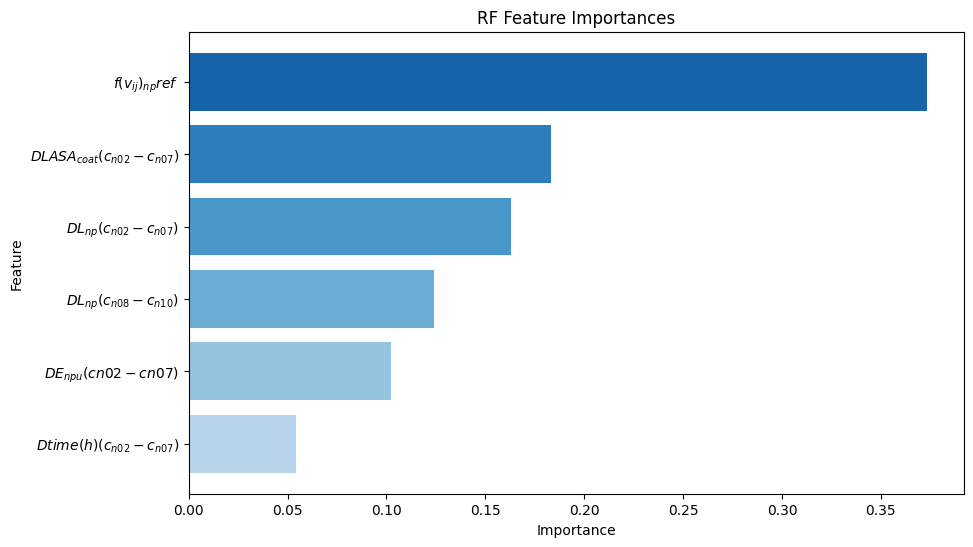

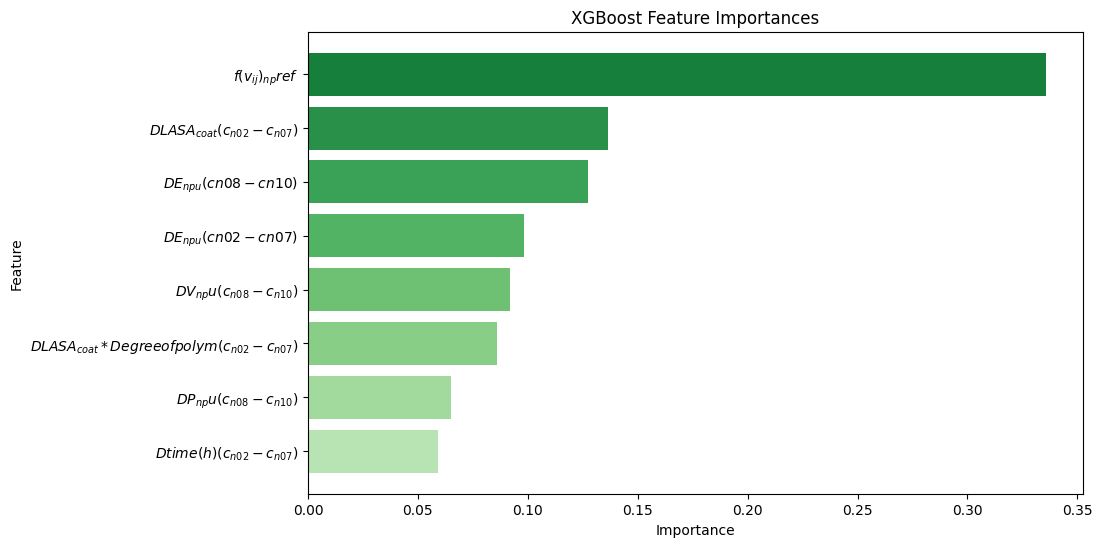

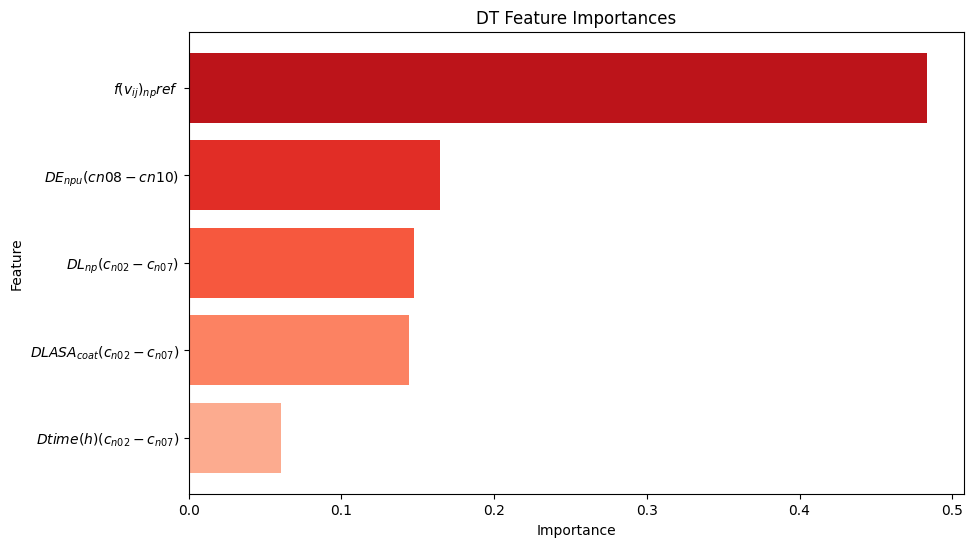

In [13]:
def plot_feature_importances(model, model_name, selected_features):
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        
        # Plot for selected features
        selected_indices = np.argsort(importances)[::-1][:len(selected_features)]
        selected_importances = importances[selected_indices]
        selected_features_sorted = [selected_features[i] for i in selected_indices]
        
        # Replace specific parts for subscript formatting in LaTeX to match the labels
        def format_feature(feature):
            if 'Enpu' in feature:
                feature = feature.replace('Enpu', 'E_{npu}')
            else:
                feature = feature.replace('n02', '_{n02}')
                feature = feature.replace('n07', '_{n07}')
                feature = feature.replace('n08', '_{n08}')
                feature = feature.replace('n10', '_{n10}')
                feature = feature.replace('np', '_{np}')
                feature = feature.replace('npu', '_{npu}')
                feature = feature.replace('LASAcoat', 'LASA_{coat}')
                feature = feature.replace('vij', 'v_{ij}')
            return f"${feature}$"
        
        selected_features_sorted = [format_feature(feature) for feature in selected_features_sorted]
        
        plt.figure(figsize=(10, 6))
        plt.title(f"{model_name} Feature Importances")
        
        if model_name == "RF":
            color = plt.cm.Blues
        elif model_name == "XGBoost":
            color = plt.cm.Greens
        elif model_name == "DT":
            color = plt.cm.Reds
        
        plt.barh(range(len(selected_features_sorted)), selected_importances, align="center", color=color(np.linspace(0.8, 0.3, len(selected_features_sorted))))
        plt.yticks(range(len(selected_features_sorted)), selected_features_sorted)
        plt.ylabel("Feature")
        plt.xlabel("Importance")
        plt.gca().invert_yaxis()
        plt.show()

# Plot feature importances for each model
for model_name, params in best_params.items():
    if model_name == "RF":
        model = RandomForestClassifier(**params, random_state=9)
    elif model_name == "XGBoost":
        model = XGBClassifier(**params, objective='binary:logistic', random_state=9)
    elif model_name == "DT":
        model = DecisionTreeClassifier(**params, random_state=9)
    
    selected_features_list = selected_features_dict[model_name]
    X_train_selected = X_train[selected_features_list]

    model.fit(X_train_selected, y_train)
    plot_feature_importances(model, model_name, selected_features_list)


In [14]:
plt.rcParams['font.family'] = 'Times New Roman'

# Plots of normalized confusion matrices in percentages
def plot_confusion_matrix(cm, model_name, data_type, figsize=(6, 5), cmap='Blues'):
    cm_percentage = cm * 100
    fig, ax = plt.subplots(figsize=figsize)
    
    cax = ax.matshow(cm_percentage, cmap=cmap)
    
    for (i, j), val in np.ndenumerate(cm_percentage):
        ax.text(j, i, f"{val:.2f}%", ha='center', va='center', color='black', fontsize=14)
    
    ax.set_xticks(range(cm.shape[1]))
    ax.set_yticks(range(cm.shape[0]))
    ax.set_xticklabels(['0', '1'], fontsize=14)
    ax.set_yticklabels(['0', '1'], fontsize=14)
    
    ax.xaxis.set_ticks_position('bottom')
    plt.xlabel('Predicted', fontsize=16) 
    plt.ylabel('Actual', fontsize=16)
    
    plt.title(f'{model_name} - Confusion Matrix ({data_type})', fontsize=16)
    plt.colorbar(cax)
    plt.show()

# Evaluation plots
def evaluate_and_plot(model, X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, model_name):
    if model_name == 'DT':
        train_color = '#FF5733'
        test_color = '#FF800F'
        cmap = 'Oranges'
    elif model_name == 'RF':
        train_color = '#116FAF'
        test_color = '#79bcfc'
        cmap = 'Blues'
    elif model_name == 'XGBoost':
        train_color = '#3AA63A'
        test_color = '#6de86d'
        cmap = 'Greens'


    cm_train = confusion_matrix(y_train, y_train_pred, normalize='true')
    plot_confusion_matrix(cm_train, model_name, "Training", figsize=(6, 5), cmap=cmap)

    cm_test = confusion_matrix(y_test, y_test_pred, normalize='true')
    plot_confusion_matrix(cm_test, model_name, "Test", figsize=(6, 5), cmap=cmap)

    # Train and test predicted probability calculation
    if hasattr(model, "predict_proba"):
        y_train_score = model.predict_proba(X_train)[:, 1]
        y_test_score = model.predict_proba(X_test)[:, 1]
    else:
        y_train_score = model.decision_function(X_train)
        y_test_score = model.decision_function(X_test)

    # ROC-AUC calculation
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_score)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_score)
    roc_auc_train = auc(fpr_train, tpr_train)
    roc_auc_test = auc(fpr_test, tpr_test)

    # Plots of ROC-curves
    plt.figure(figsize=(8, 7))
    plt.plot(fpr_train, tpr_train, color=train_color, lw=4, label=f'Train ROC (area = {roc_auc_train:.4f})')
    plt.plot(fpr_test, tpr_test, color=test_color, lw=4, label=f'Test ROC (area = {roc_auc_test:.4f})')
    plt.plot([0, 1], [0, 1], color='darkgrey', lw=2, linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.title(f'{model_name} - AUC-ROC (Train vs Test)', fontsize=20)
    plt.legend(loc="lower right", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

    # Plot of RandomForestClassifier trees
    if isinstance(model, RandomForestClassifier):
        plt.figure(figsize=(20, 15)) 
        plot_tree(model.estimators_[0], feature_names=X_train.columns, filled=True, fontsize=8)  # First tree
        plt.title(f'First Tree of {model_name}', fontsize=1)
        plt.show()


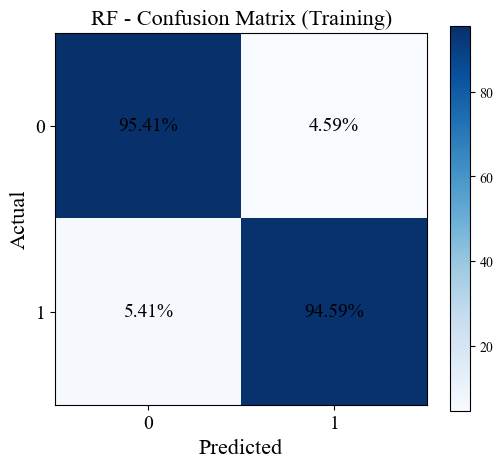

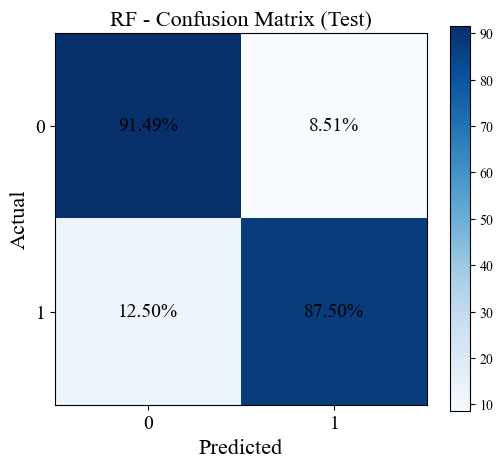

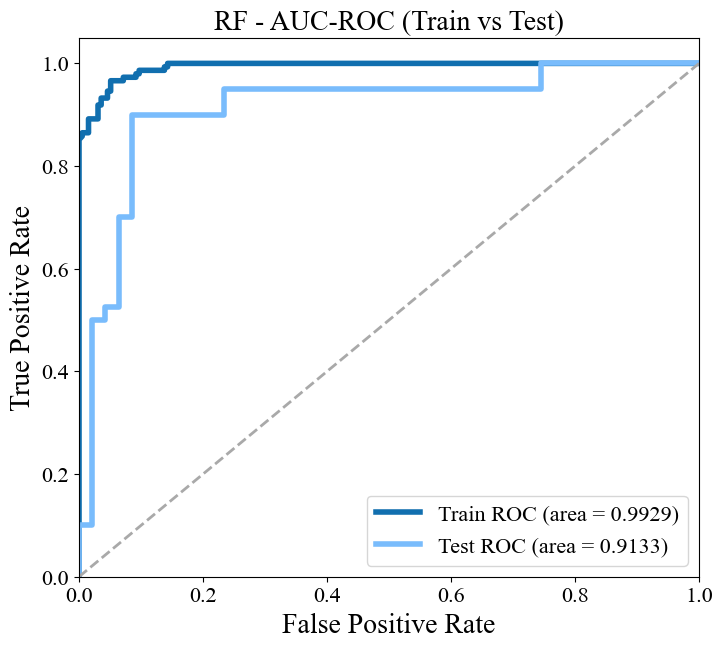

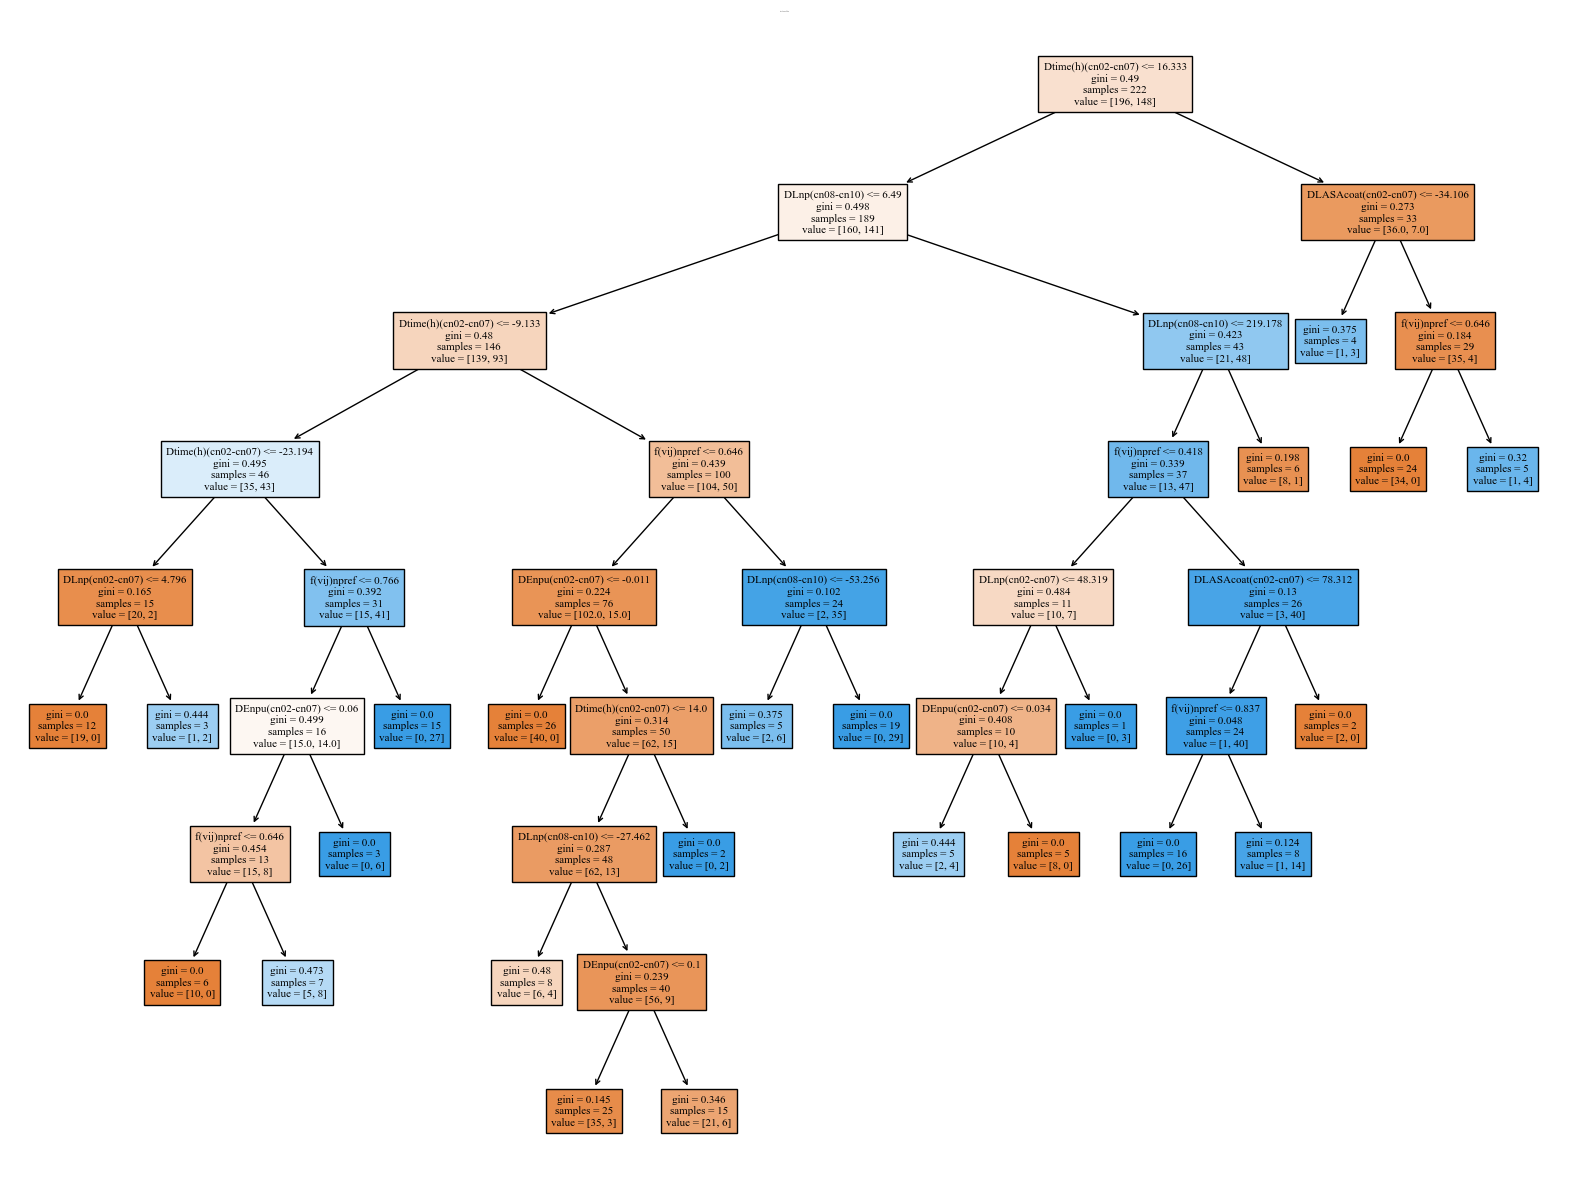

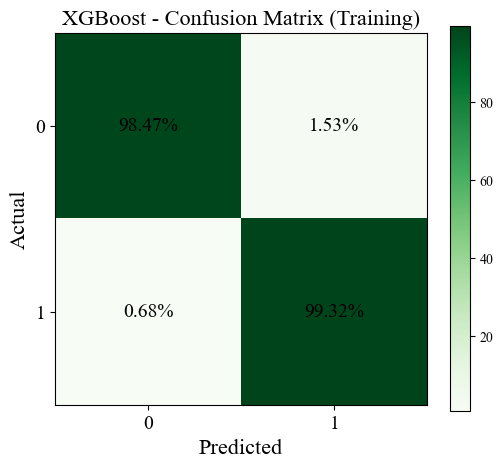

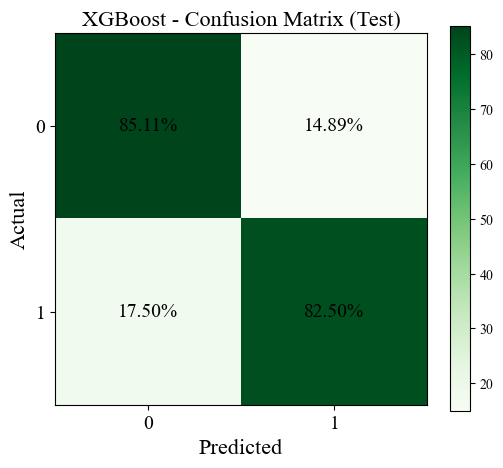

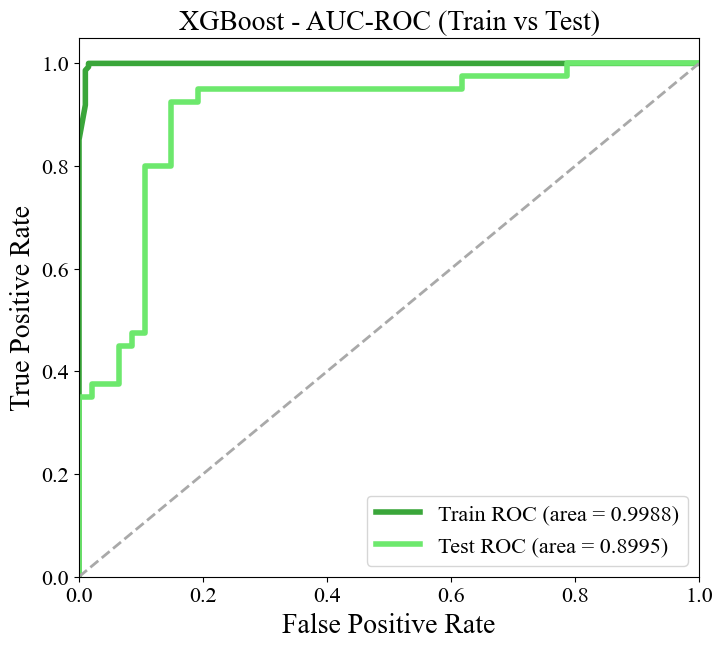

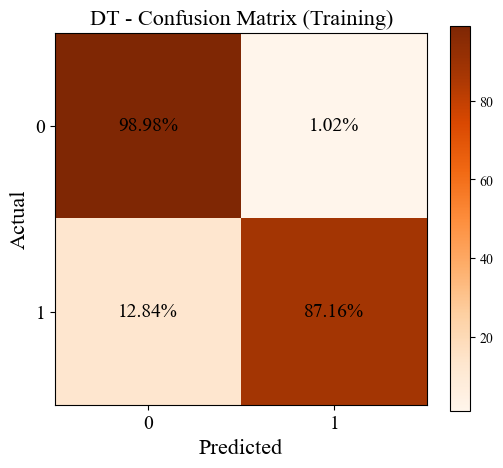

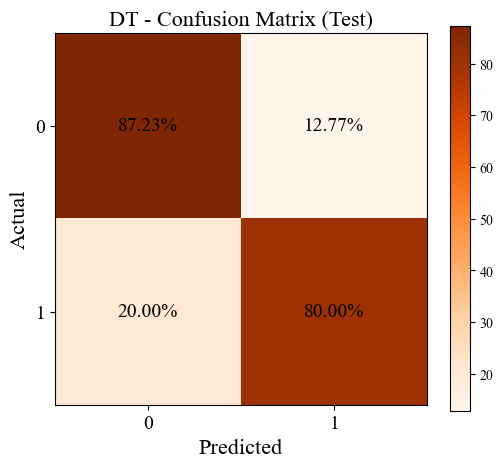

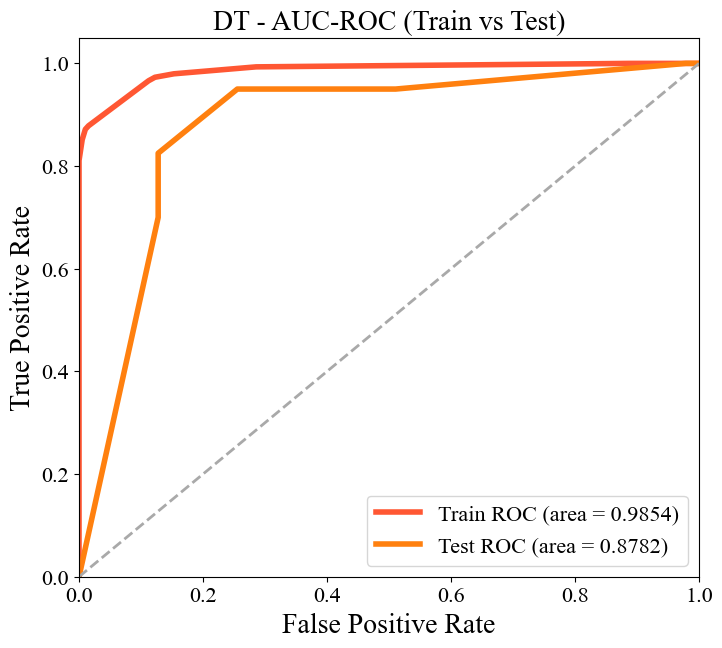

In [15]:
# Evaluation of each model
for model_name, params in best_params.items():
    if model_name == "RF":
        model = RandomForestClassifier(**params, random_state=9)
    elif model_name == "XGBoost":
        model = XGBClassifier(**params, objective='binary:logistic', random_state=9)
    elif model_name == "DT":
        model = DecisionTreeClassifier(**params, random_state=9)

    selected_features_list = selected_features_dict[model_name]
    X_train_selected = X_train[selected_features_list]
    X_test_selected = X_test[selected_features_list]
    
    metrics, y_train_pred, y_test_pred, model = evaluate_model(model, X_train_selected, y_train, X_test_selected, y_test)
    evaluate_and_plot(model, X_train_selected, y_train, X_test_selected, y_test, y_train_pred, y_test_pred, model_name)

# Save the optimal model

In [16]:
# Random Forest model
joblib.dump(trained_optimal_models['RF'], "RF.pkl")

['RF.pkl']